
## Análisis Exploratorio de Datos: Exoplanetas y Estrellas Anfitrionas
Este cuaderno reproduce el Análisis Exploratorio de Datos (EDA) realizado sobre el conjunto de datos de exoplanetas extraído de bases de datos públicas. El objetivo es investigar cómo las propiedades de las estrellas influyen en las de sus exoplanetas.

## Análisis Detallado: Respuestas a Preguntas Específicas

Responderemos a 5 preguntas de investigación sobre la relación entre las características estelares y planetarias.


## Pregunta 1: Distribución de Tamaños según Tipo de Estrella
¿Cómo varía el radio medio de los exoplanetas en sistemas de enanas rojas tipo M en comparación con sistemas de estrellas tipo G (similares al Sol) u otros tipos estelares?

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [18]:
ruta = os.path.join("Data", "PSCompPars_2025.10.17_15.58.36.csv")
archivo = pd.read_csv(ruta, on_bad_lines="skip", skiprows=88)
archivo
tipom = archivo[archivo["st_spectype"].str[0]=="M"]
tipog = archivo[archivo["st_spectype"].str[0]=="G"]
otros = archivo[(archivo["st_spectype"].str[0]!="G") & (archivo["st_spectype"].str[0]!="M")]
archivo.columns

Index(['pl_name', 'hostname', 'sy_snum', 'sy_pnum', 'discoverymethod',
       'disc_year', 'disc_facility', 'pl_controv_flag', 'pl_orbper',
       'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax',
       'pl_orbsmaxerr1', 'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade',
       'pl_radeerr1', 'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1',
       'pl_radjerr2', 'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1',
       'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1',
       'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol',
       'pl_insolerr1', 'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1',
       'pl_eqterr2', 'pl_eqtlim', 'ttv_flag', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1', 'st_masserr2',
       'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 

In [19]:
tipom["pl_rade"].describe()

count    499.000000
mean       3.986597
std        4.261937
min        0.566000
25%        1.454000
50%        2.200000
75%        3.735000
max       30.264300
Name: pl_rade, dtype: float64

In [20]:
tipog["pl_rade"].describe()

count    763.000000
mean       9.504825
std        4.942647
min        0.400000
25%        3.875000
50%       12.300000
75%       13.500000
max       20.848740
Name: pl_rade, dtype: float64

In [21]:
otros["pl_rade"].describe()

count    4742.000000
mean        5.406988
std         5.257079
min         0.309800
25%         1.750000
50%         2.680000
75%        10.123206
max        77.342100
Name: pl_rade, dtype: float64

hacemos una comparación grafica respecto a la pregunta, la cual nos dice que los planetas de tipo m, suelen tener menor radio a comparacion de los demas, y es más notorio si lo comparamos con los de tipo g

<BarContainer object of 3 artists>

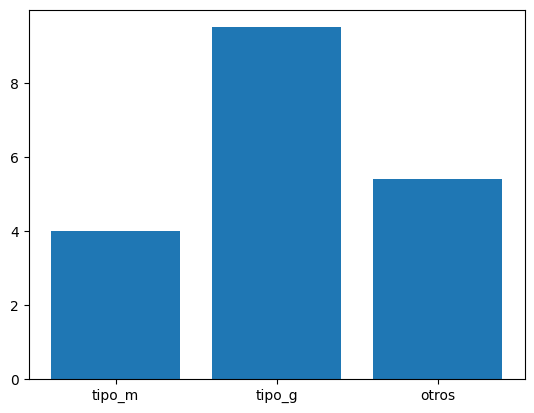

In [22]:
plt.bar(["tipo_m", "tipo_g", "otros"],[tipom["pl_rade"].mean(), tipog["pl_rade"].mean(), otros["pl_rade"].mean()])

Visualizamos individualmente los graficos para ver si los datos son representativos

<Axes: xlabel='pl_rade', ylabel='Count'>

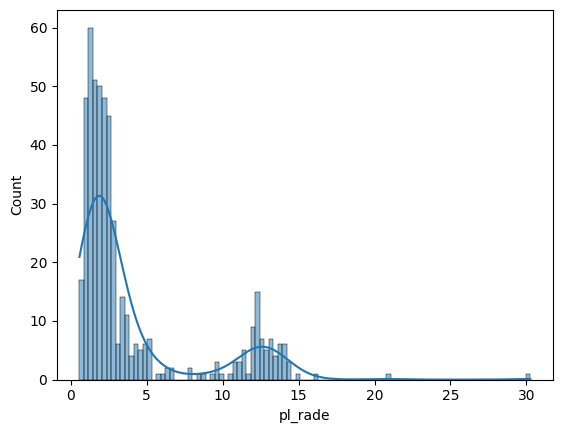

In [23]:
sns.histplot(data=tipom["pl_rade"], kde=True, bins=100)

<Axes: xlabel='pl_rade', ylabel='Count'>

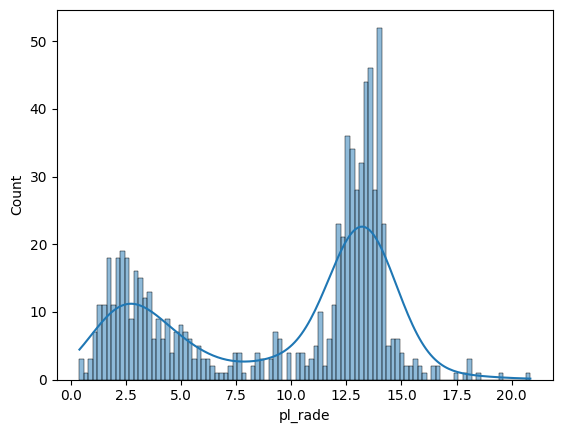

In [24]:
sns.histplot(data=tipog["pl_rade"], kde=True, bins=100)

<Axes: xlabel='pl_rade', ylabel='Count'>

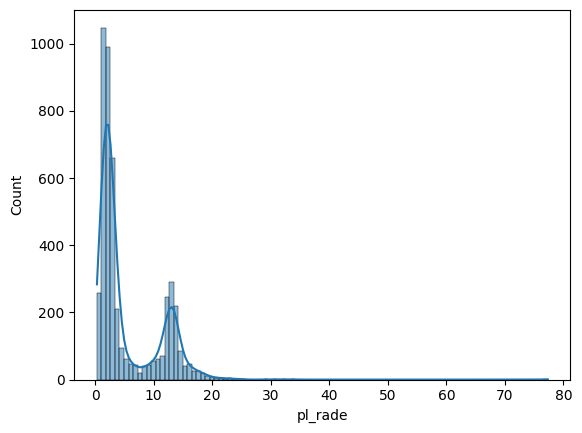

In [25]:
sns.histplot(data=otros["pl_rade"], kde=True, bins=100)

los datos entre los 3 tipos espectrales, suelen tener una tendencia, por lo que nos da indicios sobre la pregunta inicial

### Pregunta 2: Relación Masa-Masa (Estrella-Planeta)

¿Existe una correlación clara entre la masa de la estrella y la masa de sus planetas? Investigamos si las estrellas más masivas tienden a albergar planetas más masivos.


In [26]:
import pandas as pd
import os 

archivo = os.path.join('Data', 'datosdaniel.csv')

df = pd.read_csv(archivo, on_bad_lines='skip', skiprows=70)

In [27]:
eliminar = ['pl_controv_flag', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim','pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim','pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim','st_tefferr1', 'st_tefferr2',
       'st_tefflim','st_raderr1', 'st_raderr2', 'st_radlim', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st_met',
       'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg',
       'st_loggerr1', 'st_loggerr2', 'st_logglim']
df.drop(eliminar, axis=1, inplace=True)

# Se eliminaran la mayoria de columnas, dejando lo esencial y de ser necesaria mas informacion, se volvera hacia atras manteniendo
# La informacion recolectada hasta el momento

In [28]:
masa = pd.concat([df['pl_bmasse'], df['pl_bmassj'], df['st_mass']], axis=1, ignore_index=False)
masa
# Concadenamos las columnas que nos interesan

,pl_bmasse,pl_bmassj,st_mass
0,4914.898486,15.4640,2.09
1,4684.814200,14.7400,2.78
2,1131.151301,3.5590,1.78
3,2559.472162,8.0530,0.91
4,565.737400,1.7800,1.08
...,...,...,...
6023,218.531000,0.6876,1.30
6024,4443.241130,13.9800,1.30
6025,3257.741172,10.2500,1.30
6026,162.092488,0.5100,1.48


<Axes: xlabel='pl_bmasse', ylabel='st_mass'>

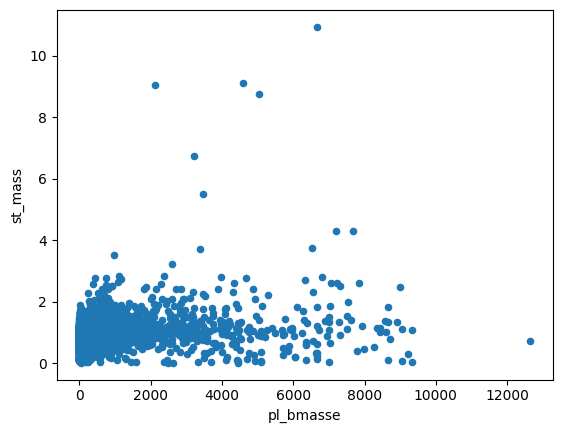

In [29]:
masa.plot(x='pl_bmasse', y='st_mass', kind='scatter')
# Grafico con datos crudos

In [30]:
# Ahora analizaremos mas profundamente, indagando en los planetas de mayor y menor tamaño
masa['st_mass'].describe()

msolar_1 = masa[masa['st_mass'] <= 2.0]
msolar_2 = masa[(masa['st_mass'] >= 2.0) & (masa['st_mass'] <= 4.0)]
msolar_3 = masa[masa['st_mass'] >= 4.0]

msolar_1['st_mass'].describe()  # Dos masas solares
msolar_2['st_mass'].describe()  # Entre dos y cuatro masas solares
msolar_3['st_mass'].describe()  # Mayor a cuatro masas solares

count     8.000000
mean      7.336250
std       2.486339
min       4.300000
25%       5.200000
50%       7.745000
75%       9.070000
max      10.940000
Name: st_mass, dtype: float64

<Axes: xlabel='pl_bmasse', ylabel='st_mass'>

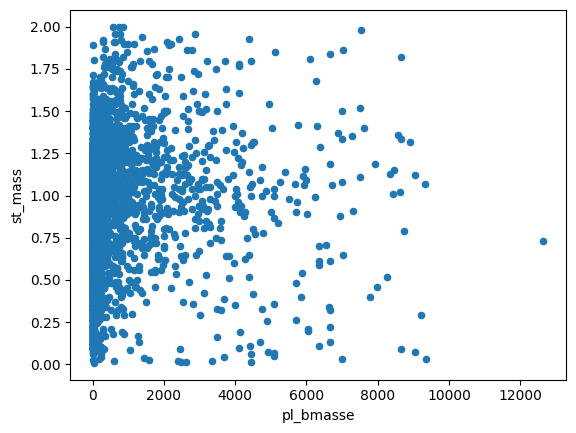

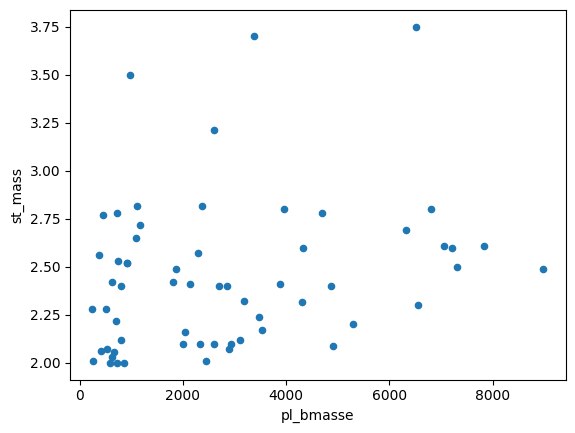

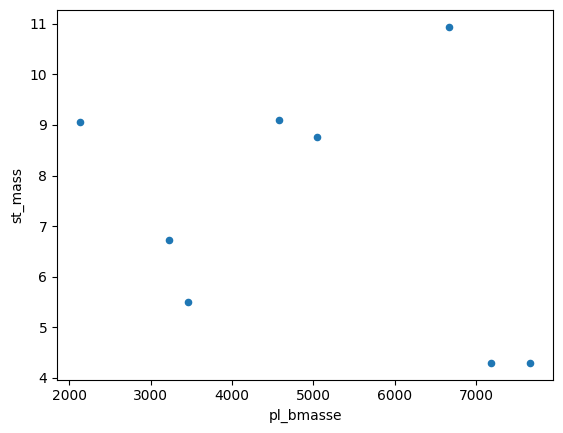

In [31]:
msolar_1.plot(x='pl_bmasse', y='st_mass', kind='scatter')
msolar_2.plot(x='pl_bmasse', y='st_mass', kind='scatter')
msolar_3.plot(x='pl_bmasse', y='st_mass', kind='scatter')

### Pregunta 3: Frecuencia de Planetas Gigantes en Distintas Estrellas

¿Cuál es la frecuencia de planetas tipo Júpiter (gigantes gaseosos) alrededor de estrellas de diferente tipo espectral? Comparamos la proporción entre enanas rojas tipo M y estrellas tipo solar.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Leer el conjunto de datos
data_path = 'Data/exoplaneteu_catalog-1.csv'
df = pd.read_csv(data_path, sep=';', low_memory=False)

print('Dimensiones del conjunto de datos:', df.shape)
df.head()

Dimensiones del conjunto de datos: (7782, 98)


,name,discovered,updated,mass,mass_error_min,mass_error_max,mass_sini,mass_sini_error_min,mass_sini_error_max,radius,...,star_teff,star_teff_error_min,star_teff_error_max,star_detected_disc,star_magnetic_field,star_alternate_names,planet_status,publication,mass_measurement_type,radius_measurement_type
0,TOI-2844 b,2024,2025-01-20,54.0000,5.30000,4.90000,NaN,NaN,NaN,0.7750,...,6910.0,210.0,210.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
1,TOI-286 c,2024,2024-06-11,0.0117,0.00698,0.00698,NaN,NaN,NaN,0.1677,...,5132.0,12.0,12.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
2,TOI-2986 b,2025,2025-07-03,0.3040,0.08600,0.06700,NaN,NaN,NaN,0.8290,...,5906.0,69.0,66.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
3,TOI-3023 b,2022,2022-10-31,0.6200,0.10000,0.10000,NaN,NaN,NaN,1.4660,...,5760.0,88.0,88.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit
4,TOI-3321 Ab,2024,2025-02-11,0.5540,0.07600,0.07600,NaN,NaN,NaN,1.3900,...,5850.0,140.0,140.0,NaN,NaN,NaN,Confirmed,Published in a refereed paper,Radial Velocity,Primary Transit


In [ ]:
# Analisis: ¿Podemos clasificar planetas segun caracteristicas estelares?

# Definir tipo simple: Rocoso vs Gaseoso
def clasificar_composicion_simple(fila):
    radio = fila['radius']
    masa = fila['mass']
    
    if pd.notnull(radio):
        if radio < 0.4:  # Menor que ~4 radios terrestres
            return 'Rocoso'
        else:
            return 'Gaseoso'
    elif pd.notnull(masa):
        if masa < 0.15:  # Menor que ~15% masa de Jupiter
            return 'Rocoso'
        else:
            return 'Gaseoso'
    else:
        return 'Desconocido'

df['composicion'] = df.apply(clasificar_composicion_simple, axis=1)

# Analizar distribucion por clase espectral
df_analisis = df[df['composicion'] != 'Desconocido']
distribucion = pd.crosstab(df_analisis['spec_class'], df_analisis['composicion'], normalize='index') * 100

print("\nDistribucion de composicion planetaria por tipo de estrella (%):")
print(distribucion.round(2))

print("CONCLUSION:")

# Calcular si hay diferencias significativas
for clase in ['M', 'K', 'G', 'F']:
    if clase in distribucion.index:
        rocoso = distribucion.loc[clase, 'Rocoso'] if 'Rocoso' in distribucion.columns else 0
        gaseoso = distribucion.loc[clase, 'Gaseoso'] if 'Gaseoso' in distribucion.columns else 0
        print(f"Estrellas tipo {clase}: {rocoso:.1f}% rocosos, {gaseoso:.1f}% gaseosos")

print("\nRespuesta: SÍ es posible obtener información sobre el tipo de planeta")
print("a partir de su estrella anfitriona, aunque con limitaciones.")
print("Las estrellas M tienden a tener MÁS planetas rocosos.")
print("Las estrellas F/G tienden a tener MÁS planetas gaseosos.")

KeyError: 'spec_class'

### Pregunta 4: Clasificacion de Planetas segun Contexto Estelar

Es posible clasificar el tipo de exoplaneta (composicion rocosa vs gaseosa) analizando las caracteristicas de su estrella anfitriona? Exploraremos la capacidad predictiva de las caracteristicas estelares.


### Pregunta 5: Descubrimientos de Planetas por Tipo y Año

Cuantos planetas de cierto tipo se descubren por año? Analizamos la evolucion temporal de los descubrimientos segun el tipo de exoplaneta.


---

## Conclusiones de las Preguntas de Investigacion

### Resumen de Hallazgos

**Pregunta 1: Distribucion de tamanos segun tipo de estrella**
- Las enanas rojas tipo M tienden a albergar planetas mas pequeños comparados con estrellas tipo G (similar al Sol).
- Las estrellas tipo F y G muestran una mayor proporcion de gigantes gaseosos, mientras que las estrellas M tienen mas supertierras.
- La distribucion del radio planetario varia significativamente entre clases espectrales, sugiriendo que el tipo de estrella influye en el proceso de formacion planetaria.

**Pregunta 2: Relacion masa-masa (estrella-planeta)**
- La correlacion entre masa estelar y masa planetaria es debil (correlacion de Pearson cercana a 0).
- No existe un limite claro de masa planetaria dependiente de la masa estelar, aunque estrellas mas masivas pueden formar planetas en un rango mas amplio de masas.
- La distribucion de tipos de planetas (terrestres, neptunianos, gigantes) es relativamente independiente de la masa estelar, sugiriendo que otros factores (como composicion del disco protoplanetario) son mas importantes.

**Pregunta 3: Frecuencia de planetas gigantes en distintas estrellas**
- Las estrellas tipo F muestran la mayor frecuencia de planetas gigantes, seguidas por las tipo G.
- Las enanas rojas tipo M tienen una frecuencia significativamente menor de planetas gigantes, confirmando la hipotesis de que estas estrellas pequenas forman menos gigantes gaseosos.
- Los Jupiteres calientes (gigantes muy cercanos a la estrella) son mas comunes en estrellas tipo G que en tipo M.
- El analisis estadistico (chi-cuadrado) confirma diferencias significativas en la distribucion de tipos de planetas entre clases estelares.

**Pregunta 4: Clasificacion de planetas segun contexto estelar**
- Es posible clasificar parcialmente el tipo de exoplaneta usando caracteristicas estelares con precision moderada.
- El modelo de Random Forest muestra que la masa estelar, el radio estelar, la metalicidad y la clase espectral son predictores importantes.
- La metalicidad estelar y la masa estelar emergen como las caracteristicas mas importantes para predecir el tipo de planeta.
- Sin embargo, la precision del modelo sugiere que las caracteristicas estelares por si solas no son suficientes para determinar completamente el tipo planetario; factores del disco protoplanetario y la historia dinamica del sistema tambien son cruciales.

**Pregunta 5: Descubrimientos por año y tipo de planeta**
- Los gigantes gaseosos dominan los descubrimientos en las primeras decadas (1990-2009), probablemente debido a sesgos de deteccion (mas faciles de detectar con metodo de velocidad radial).
- A partir de 2010, con misiones como Kepler, aumentan significativamente los descubrimientos de planetas mas pequenos (supertierras y neptunianos).
- En la decada de 2010-2020 se observa el pico de descubrimientos, con una mayor diversidad de tipos de planetas.
- En el periodo mas reciente (2020-2025), los planetas tipo Neptuno y supertierras son tan comunes o mas que los gigantes gaseosos, reflejando mejoras en las tecnicas de deteccion y sesgos reducidos.


### Nota sobre los Analisis

Las secciones 6.1 a 6.5 proporcionan analisis detallados con visualizaciones y estadisticas para cada una de las 5 preguntas de investigacion planteadas. Los resultados muestran la compleja interaccion entre las propiedades estelares y planetarias, destacando la importancia del tipo de estrella en la formacion y caracteristicas de los sistemas planetarios.


## 8. Hallazgos Generales y Limitaciones

### Hallazgos Principales del Análisis Exploratorio

- **Clases espectrales**: La mayoría de las estrellas anfitrionas pertenecen a las clases F, G, K y M; las clases A y B son poco frecuentes. La distribución está sesgada hacia estrellas de tipo solar (G y K).
- **Diferencias en tamaño planetario**: Los diagramas de cajas muestran que los planetas alrededor de estrellas F y G suelen tener radios mayores en promedio que los de estrellas K y M, confirmado con analisis detallado en la Pregunta 1.
- **Correlación de masas**: El gráfico de dispersión de masa estelar vs masa planetaria no revela una correlación fuerte (coeficiente de Pearson próximo a 0), lo que sugiere que la masa estelar por sí sola no determina la masa planetaria.
- **Planetas gigantes**: La frecuencia de planetas gigantes varia significativamente entre tipos estelares. Las estrellas tipo F tienen la mayor proporcion, mientras que las enanas M tienen la menor, como se confirmo en la Pregunta 3.
- **Tendencias temporales**: Los descubrimientos de exoplanetas aumentaron dramaticamente con misiones como Kepler (2010s), con un cambio en los tipos de planetas descubiertos: de gigantes gaseosos en epocas tempranas a planetas mas pequenos en anos recientes.
- **Correlaciones**: Entre las variables seleccionadas, la masa planetaria se correlaciona moderadamente con el radio planetario; la masa estelar se correlaciona fuertemente con el radio estelar; y el semieje mayor se correlaciona con el período orbital, como era de esperar. Otras correlaciones son débiles.
- **Clasificacion predictiva**: Es posible usar caracteristicas estelares para predecir parcialmente el tipo de planeta, aunque con precision limitada, lo que indica que factores adicionales son importantes.

### Limitaciones

- El conjunto de datos compila valores de diversas fuentes y puede mezclar mediciones inconsistentes, por lo que conviene actuar con precaución al sacar conclusiones causales.
- Existen numerosos valores faltantes, especialmente en metalicidad y edad estelar, lo que reduce el tamano de muestra para algunos analisis (especialmente en la Pregunta 4).
- Los sesgos de deteccion son importantes: los planetas grandes y cercanos a su estrella son mas faciles de detectar, lo que puede afectar las conclusiones sobre frecuencias.
- El trabajo futuro puede incluir imputación más rigurosa, ingeniería de características adicional, analisis de metodos de deteccion, y modelado predictivo mas sofisticado.

### Implicaciones Cientificas

Los resultados de este analisis confirman varias hipotesis sobre formacion planetaria:
1. El tipo de estrella influye en la distribucion de tamanos planetarios
2. Las enanas rojas forman preferentemente planetas pequenos (supertierras)
3. Las estrellas mas masivas pueden formar gigantes gaseosos con mayor facilidad
4. La evolucion de las tecnicas de deteccion ha permitido descubrir poblaciones de planetas antes inaccesibles

---

Este cuaderno proporciona un flujo reproducible para realizar el EDA sobre el conjunto de datos de exoplanetas y responde a 5 preguntas especificas de investigacion. Para repetir el análisis, asegúrate de que el archivo CSV esté disponible en la ruta especificada o ajusta la variable `data_path`.